In [4]:
!pip install matplotlib

  Using cached matplotlib-3.10.6-cp313-cp313-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pillow-11.3.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.0 kB)
Using cached matplotlib-3.10.6-cp313-cp313-macosx_11_0_arm64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl (274 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 5.1 MB/s eta 0:00:00a 0:00:01
Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl (64 kB)
Using cached pillow-11.3.0-cp313-cp313-macosx_11_0_arm64.whl (4.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgr

Prix de l’option: 0.4296011882049263
Black-Scholes Price: 0.7850


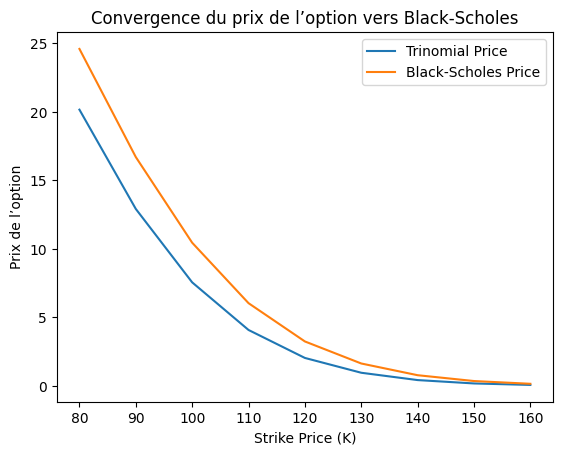

In [ ]:

# import numpy as np
# from pricing import BlackScholesPricer, TrinomialTree, Market, Option




# market = Market(S0=100, r=0.05, sigma=0.2)
# option = Option(K=140, option_type="call", T=1.0)
# tree = TrinomialTree(market, option, N=100)

# price = tree.price_option()
# print("Prix de l’option:", price)

# bs_price = BlackScholesPricer().price(S=market.S0, K=option.K, T=option.T, r=market.r, q=0, sigma=market.sigma, option_type='call') # q=0 car pas de dividendes
# print("Black-Scholes Price: {:.4f}".format(bs_price))


# tree.bs_convergence_by_strike([80, 90, 100, 110, 120, 130, 140, 150, 160])

In [ ]:
import numpy as np
import pandas as pd
from blackscholes import BlackScholesPricer

class Market:
    def __init__(self, S0, r, sigma, D=None):
        self.S0 = S0
        self.r = r
        self.sigma = sigma
        self.D = D if D is not None else []

class Option:
    def __init__(self, K, option_type, T):
        self.K = K
        self.option_type = option_type
        self.T = T

class Node:
    def __init__(self, S, proba, up, down, next_up, next_mid, next_down):
        self.S = S      # Prix du sous-jacent au nœud
        self.proba = proba  # Probabilité d'atteindre ce nœud
        self.up = up    # Nœud "up" frère
        self.down = down# Nœud "down" frère
        self.next_up = next_up    # Nœud "up" prochain
        self.next_mid = next_mid  # Nœud "mid" prochain
        self.next_down = next_down# Nœud "down" prochain
        # il faudra rajouter option value ici pour le pricing
        # il faut donner l'objet option à la racine de l’arbre
        # on doit pouvoir faire tree.root.price(option)
        # pour le pricing si next mid est None alors on est à la fin de l’arbre et on doit pricer

        # la valeur intrinsèque ou payoff doit être une methode de la classe option 
        # et on doit lui donner node.S pour pricer

class TrinomialTree:
    # ce serait bien de lui faire hériter de Model (voir moodle) une fonction check probability et str_pc, les deux en staticmethod
    def __init__(self, market, option, N):
        self.market = market
        self.option = option
        self.N = N
        self.delta_t = option.T / N
        self.alpha = np.exp(market.sigma * np.sqrt(3 * self.delta_t))

        # Probabilités (communes à tout l’arbre)
        forward_1 = np.exp(self.market.r * self.delta_t) * self.market.S0
        variance_1 = (
            self.market.S0**2 *
            np.exp(2 * self.market.r * self.delta_t) *
            (np.exp(self.market.sigma**2 * self.delta_t) - 1)
        )
        self.p_down = (
            (forward_1**(-2) * (variance_1 + forward_1**2) - 1 -
             (self.alpha+1) * (forward_1**(-1)*forward_1 - 1))
            / ((1 - self.alpha) * (self.alpha**(-2) - 1))
        )
        self.p_up = self.p_down / self.alpha
        self.p_mid = 1 - self.p_up - self.p_down

        # rajout de la construction de l'arbre
        self.root = self._build_tree()



    def _build_tree(self):

        # Créer le nœud racine
        root = Node(
            S=self.market.S0,
            proba=1.0,
            up=None,
            down=None,
            next_up=None,
            next_mid=None,
            next_down=None
        )

        current_node = root

        for i in range(self.N + 1):
            
            next_mid = Node(
                S=current_node.S*np.exp(self.market.r * self.delta_t),
                proba=current_node.proba * self.p_mid,
                up=None,
                down=None,
                next_up=current_node.next_mid.up if i <= self.N else None,
                next_mid=None,
                next_down=current_node.next_mid.down if i <= self.N else None
            )

            current_node.next_mid = next_mid
            current_node = next_mid

            n = 0
            while n<=i:
                up = Node(
                    S=current_node.S * self.alpha,
                    proba=current_node.proba * self.p_up,
                    up=None,
                    down=current_node,
                    next_up=None,
                    next_mid=None,
                    next_down=None
                )

                current_node.up = up
                current_node = up

                n += 1

            # on revient au milieu
            current_node = next_mid

            n=0
            while n<=i:
                down = Node(
                    S=current_node.S / self.alpha,
                    proba=current_node.proba * self.p_down,
                    up=current_node,
                    down=None,
                    next_up=None,
                    next_mid=None,
                    next_down=None
                )
                current_node.down = down
                current_node = down

                n += 1

        return root


market = Market(S0=100, r=0.05, sigma=0.2)
option = Option(K=140, option_type="call", T=1.0)
tree = TrinomialTree(market, option, N=2)

tree.root.next_up.S

 

AttributeError: 'NoneType' object has no attribute 'S'